In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pulp import LpVariable as var, LpProblem, LpStatus, value

from lib import gen_power as wind_gen

plt.rcParams.update({'font.size': 18})
%config InlineBackend.figure_format = 'retina'

In [4]:
nrows = 800
df = pd.read_csv('data/uninterpolated_novikovo.csv', nrows=nrows)

In [5]:
df.head()

,time,v,T
0,22.02.2012 11:00:00,0.4,-6.3
1,22.02.2012 11:10:00,0.4,-9.2
2,22.02.2012 11:20:00,0.4,-8.3
3,22.02.2012 11:30:00,0.4,-7.7
4,22.02.2012 11:40:00,0.4,-7.0


In [6]:
v = df.v.values
v = np.array([v[i * 6: (i+1) * 6].sum() / len(v[i * 6: (i+1) * 6]) for i in range(int(v.shape[0] / 6) + 1)])

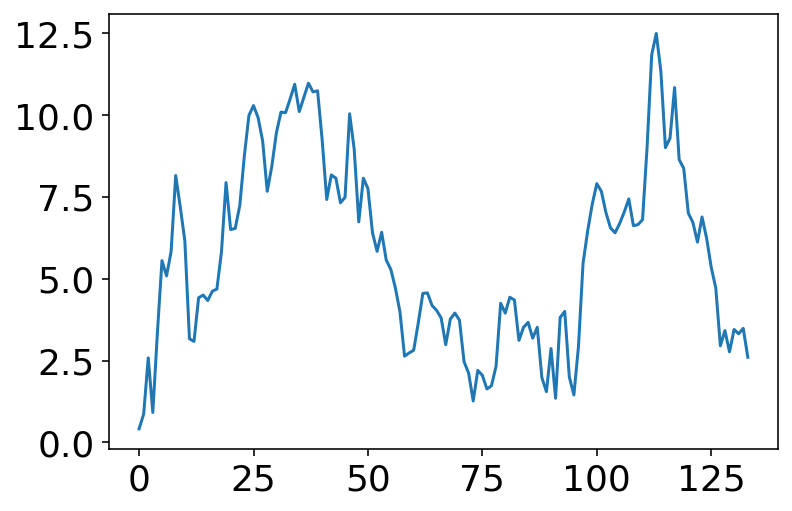

In [7]:
plt.plot(v)

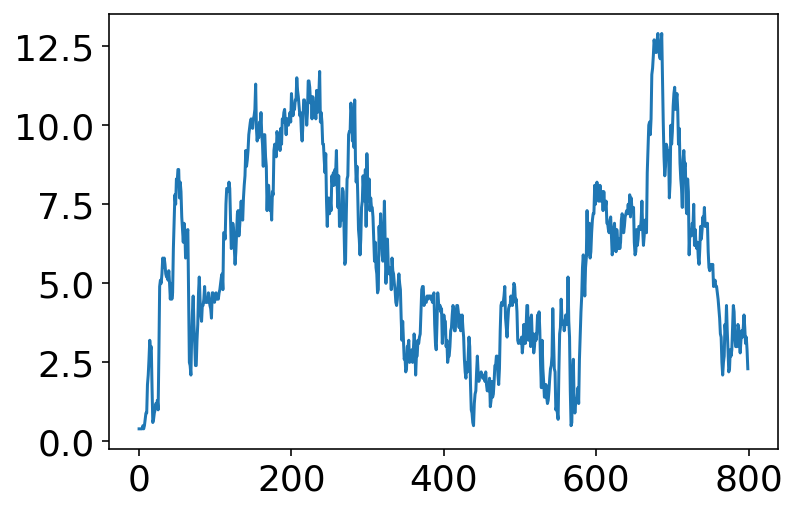

In [8]:
plt.plot(df.v.values)

In [9]:
# timestep = 1h , power in kW/h

class Battery:
    def __init__(self, capacity, max_power, resource, cost, initial_percentage=0.5):
        self.energy = initial_percentage * capacity
        self.capacity = capacity
        self.max_power = max_power
        self.resource = resource # in kW * h discharge
        self.resource_remain = self.resource
        self.cost = cost
        self.discharge_slope = self.cost / self.resource
        self.payed = 0
        self.received = 0
        
    def get_percentage(self):
        return self.energy / self.capacity
   
    def range(self): # with sign
        return [max(-self.max_power, -self.energy), min(self.max_power, self.capacity - self.energy)]
        
    def charge(self, power, cost):
        # power = min(power, self.range()[1])
        self.energy += power
        if self.energy > self.capacity:
            if self.energy - self.capacity < 1e-5: self.energy = self.capacity
            else: assert(False)
        self.payed += cost * power
        self.received += power
        return power
    
    # output is negative
    def discharge(self, power):
        # power = min(power, -self.range()[0]) # timestep is 1 hour
        self.energy -= power
        if self.energy < 0:
            if self.energy > -1e-5: self.energy = 0
            else : assert(False)
        self.resource_remain -= power
        return -power
    
    def update(self, power, cost=0):
        if power > 0:
            return self.charge(power, cost)
        else:
            return self.discharge(-power)

    def cycle_cost(self, power):
        power = np.clip(power, 0, self.max_power)
        return np.clip(power, 0, self.max_power) * self.discharge_slope # timestep is 1 hour
    
    def energy_cost(self):
        return self.discharge_slope / 2 if not self.received else self.payed / self.received
    
class GenSet:
    def __init__(self, max_power, consumption_intercept, full_load_consumption, cost, resource, fuel_cost,
                 maintainance_cost):
        self.max_power = max_power
        self.min_power = 0
        self.consumption_intercept = consumption_intercept
        self.consumption_slope = (full_load_consumption - consumption_intercept) / max_power
        self.cost = cost
        self.fuel_cost = fuel_cost
        self.cost_intercept = self.consumption_intercept * fuel_cost + cost / resource + maintainance_cost
        self.cost_slope = self.consumption_slope * fuel_cost
        self.resource = resource # in h
        # self.resource_remain = resource
        self.hours_worked = 0
        self.consumed = 0
        self.maintainance_cost = maintainance_cost
        
    def consumption(self, power):
        return self.consumption_intercept + self.consumption_slope * np.clip(power,
                       self.min_power, self.max_power)
    
    def update(self, power):
        power = power * (power >= 0.01)
        if power > 0:
            power = np.clip(power, self.min_power, self.max_power)
            self.hours_worked += 1
            self.consumed += self.consumption(power)
            # self.resource_remain -= power
            return power
    
    def cycle_cost(self, power):
        power = power * (power >= 0.01)
        power = np.clip(power, self.min_power, self.max_power)
        return self.cost_intercept + self.cost_slope * power # timestep is 1 hour

In [10]:
def print_vars(problem):
    for v in problem.variables():
        print(v.name, value(v), end=' ')
    print('\n')

def lf_optimize(load, wg, genset, battery, verbose=False):
    z1 = var('charge', lowBound=0, upBound=battery.range()[1]) # battery charge power
    z2 = var('discharge', lowBound=battery.range()[0], upBound=0) # battery discharge power (negative)
    y = var('genset_power', lowBound=genset.min_power, upBound=genset.max_power) # genset power
    x = var('genset_on', cat='Binary') # genset is running

    problem = LpProblem(name='load_following')

    problem += y + wg >= load + z1 + z2 # power balance
    problem += y <= x * genset.max_power # genset_power > 0 only if constant cost payed

    # charging should be encouraged but less when genset generation cost
    charge_slope = min(battery.discharge_slope, genset.consumption_slope) / 2
    problem += (-z1 * charge_slope - z2 * battery.discharge_slope + 
                x * genset.cost_intercept + y * genset.cost_slope)
    status = problem.solve()
    
    if verbose:
        print(LpStatus[status], end=' ')
        print_vars(problem)
        
    assert(status==1)
    assert(not value(z1) or not value(z2))
    
    return [value(y), value(z1) + value(z2)]

def cc_optimize(load, wg, genset, battery, verbose=False):
    gp, bp = lf_optimize(load, wg, genset, battery)
    if gp > 0:
        gp2 = min(genset.max_power, max(0, load - wg + battery.range()[1]))
        bp += gp2 - gp
        gp = gp2
        
    return gp, bp

def cc2_optimize(load, wg, genset, battery, verbose=False):
    if (battery.range()[1] < 0): print(battery.range())
    z1 = var('charge', lowBound=0, upBound=battery.range()[1]) # battery charge power
    z2 = var('discharge', lowBound=battery.range()[0], upBound=0) # battery discharge power (negative)
    x = var('genset_on', cat='Binary') # genset is running

    problem = LpProblem(name='cycle_charging')
    
    genset_mp = min(genset.max_power, max(0, load - wg + battery.range()[1]))
    problem += x * genset_mp + wg >= load + z1 + z2 # power balance
    problem += x * genset_mp <= load + z1 + z2 # power balance
    
    problem += (-(z1 + z2) * battery.energy_cost()  + (z1 - z2) * battery.discharge_slope / 2 + 
                x * (genset.cost_intercept + genset_mp * genset.cost_slope))
    status = problem.solve()
    
    if verbose:
        print(LpStatus[status], end =' ')
        print_vars(problem)
        
    assert(status==1)
    assert(not value(z1) or not value(z2))
    
    return [value(x) * genset_mp, value(z1) + value(z2)]

def test_optimize(optimize, verbose=False):
    load = 70
    capacity = 100
    wg = np.linspace(0, 100, 20)

    gp = np.zeros(wg.shape[0])
    bp = np.zeros(wg.shape[0])

    for i in range(wg.shape[0]):
        battery = Battery(capacity=capacity, max_power=3*capacity, resource=3000*capacity, cost=1000*capacity)
        genset = GenSet(max_power=100, consumption_intercept=2, full_load_consumption=0.195*100/0.85, cost=2.5e6/75,
                    resource=15000*100, fuel_cost=64/75, maintainance_cost=3)

        gp[i], bp[i] = optimize(load, wg[i], genset, battery, verbose=verbose)

    log = pd.DataFrame()
    log['wind'] = wg
    log['genset'] = gp
    log['battery'] = -bp
    log.plot(kind='bar', stacked=True, figsize=(17,6), xticks=[], 
             title=('LF' if optimize==lf_optimize else 'CC') + ' MILF', ylabel='power to grid')
    

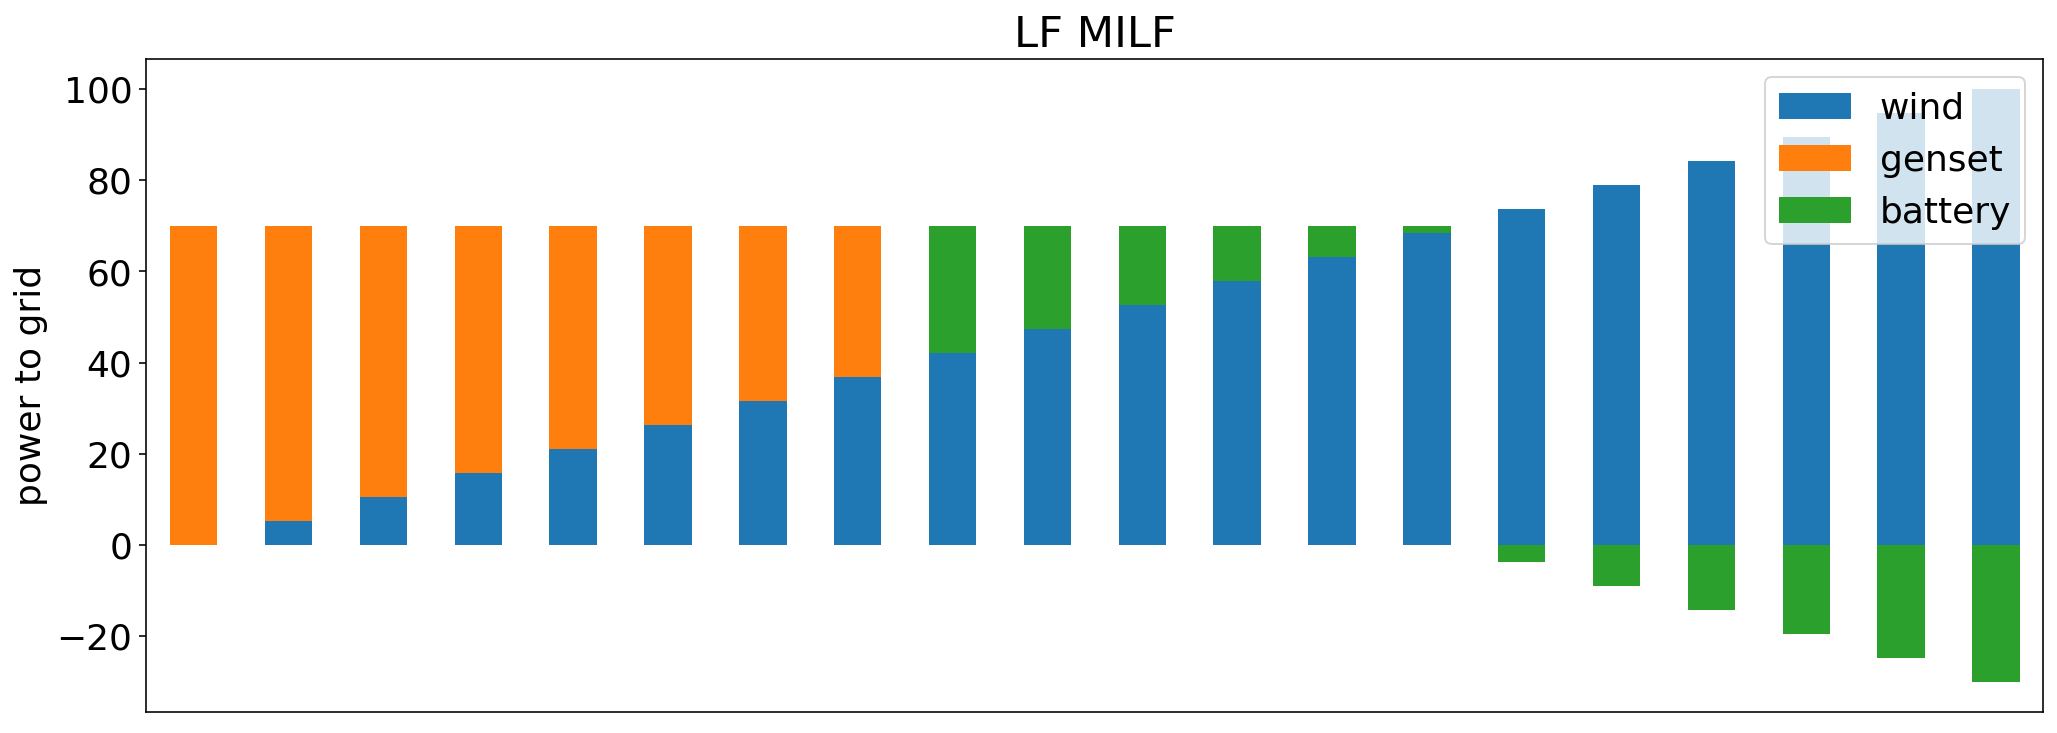

In [11]:
test_optimize(lf_optimize)

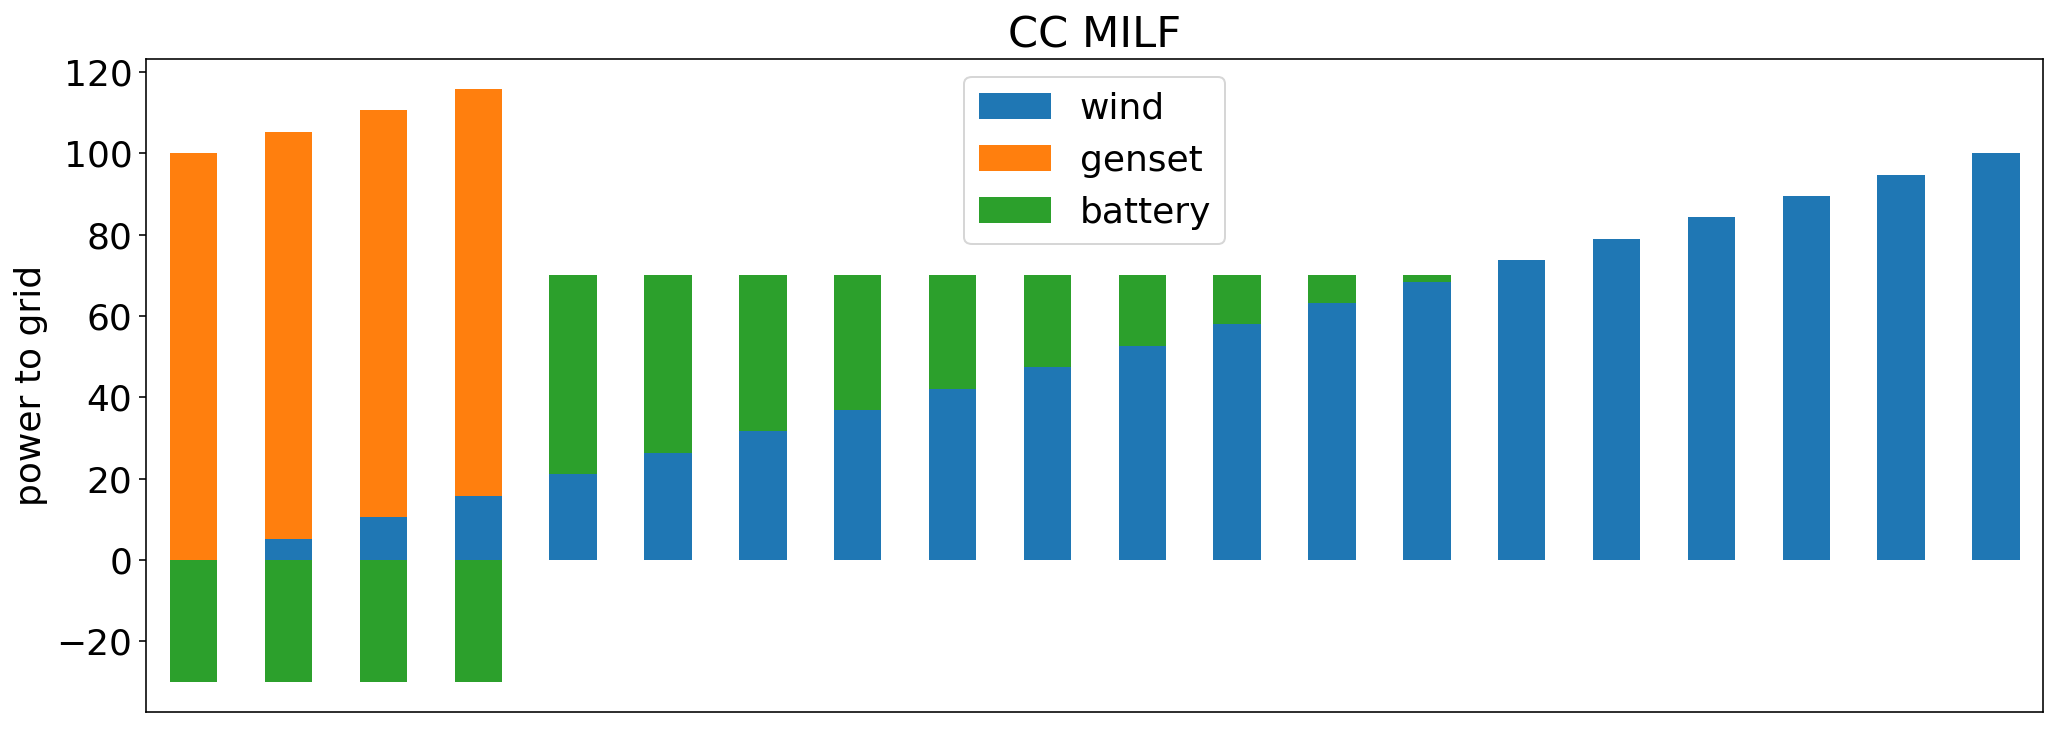

In [12]:
test_optimize(cc2_optimize, verbose=False)

In [13]:
def run(load, strategy, genset, battery, verbose=None):
    
    wg, bp, gp = [np.zeros(v.shape[0]) for _ in range(3)]

    for i in range(len(v)):
        wg[i] = wind_gen(v[i])
        
        if verbose:
            print('wg:', wg[i])
        if strategy == 'lf':
            gp[i], bp[i] = lf_optimize(load, wg[i], genset, battery, verbose=verbose)
        elif strategy == 'cc':
            gp[i], bp[i] = cc_optimize(load, wg[i], genset, battery, verbose=verbose)
        elif strategy == 'cc2':
            gp[i], bp[i] = cc2_optimize(load, wg[i], genset, battery, verbose=verbose)

        genset.update(gp[i])

        battery.update(bp[i], cost= 0 if not gp[i] else genset.cycle_cost(gp[i])/gp[i])
        
    total_cost = (battery.cost * (1 - battery.resource_remain/battery.resource) + 
                  genset.fuel_cost * genset.consumed + genset.cost_intercept * genset.hours_worked)
    print(strategy, load, int(battery.cost/100), ':', battery.resource_remain / battery.resource, 
          genset.consumed, genset.hours_worked, total_cost)  
    ind = np.arange(v.shape[0])
    # plt.bar(ind, gp, label='genset')
    # plt.bar(ind, bp, label='battery')
    # plt.legend()
    
    return wg, gp, bp

lf 70 400 : 0.9989810523957002 1668.2338636499994 100 2022.5396900422124
cc 70 400 : 0.9918913830197001 1568.0 56 1974.9757903231052
cc2 70 400 : 0.9955099094763662 1645.4231471319677 72 1985.6180398312981
lf 70 1000 : 0.9990114148083666 1661.5110446499993 97 2058.1568328202247
cc 70 1000 : 0.9969902132097054 1654.718592322388 79 2154.0007667001223
cc2 70 1000 : 0.9982378624330331 1715.3508852399964 89 2136.797623212594
lf 30 400 : 0.9990281319524338 550.7787353749999 61 849.3881316448708
cc 30 400 : 0.995527405512434 448.0 16 650.5126683915282
cc2 30 400 : 0.995527405512434 448.0 16 650.5126683915282
lf 30 1000 : 0.9990506415151004 543.4669524499999 58 882.4632034695187
cc 30 1000 : 0.995527405512434 448.0 16 918.8683376454873
cc2 30 1000 : 0.995527405512434 448.0 16 918.8683376454873


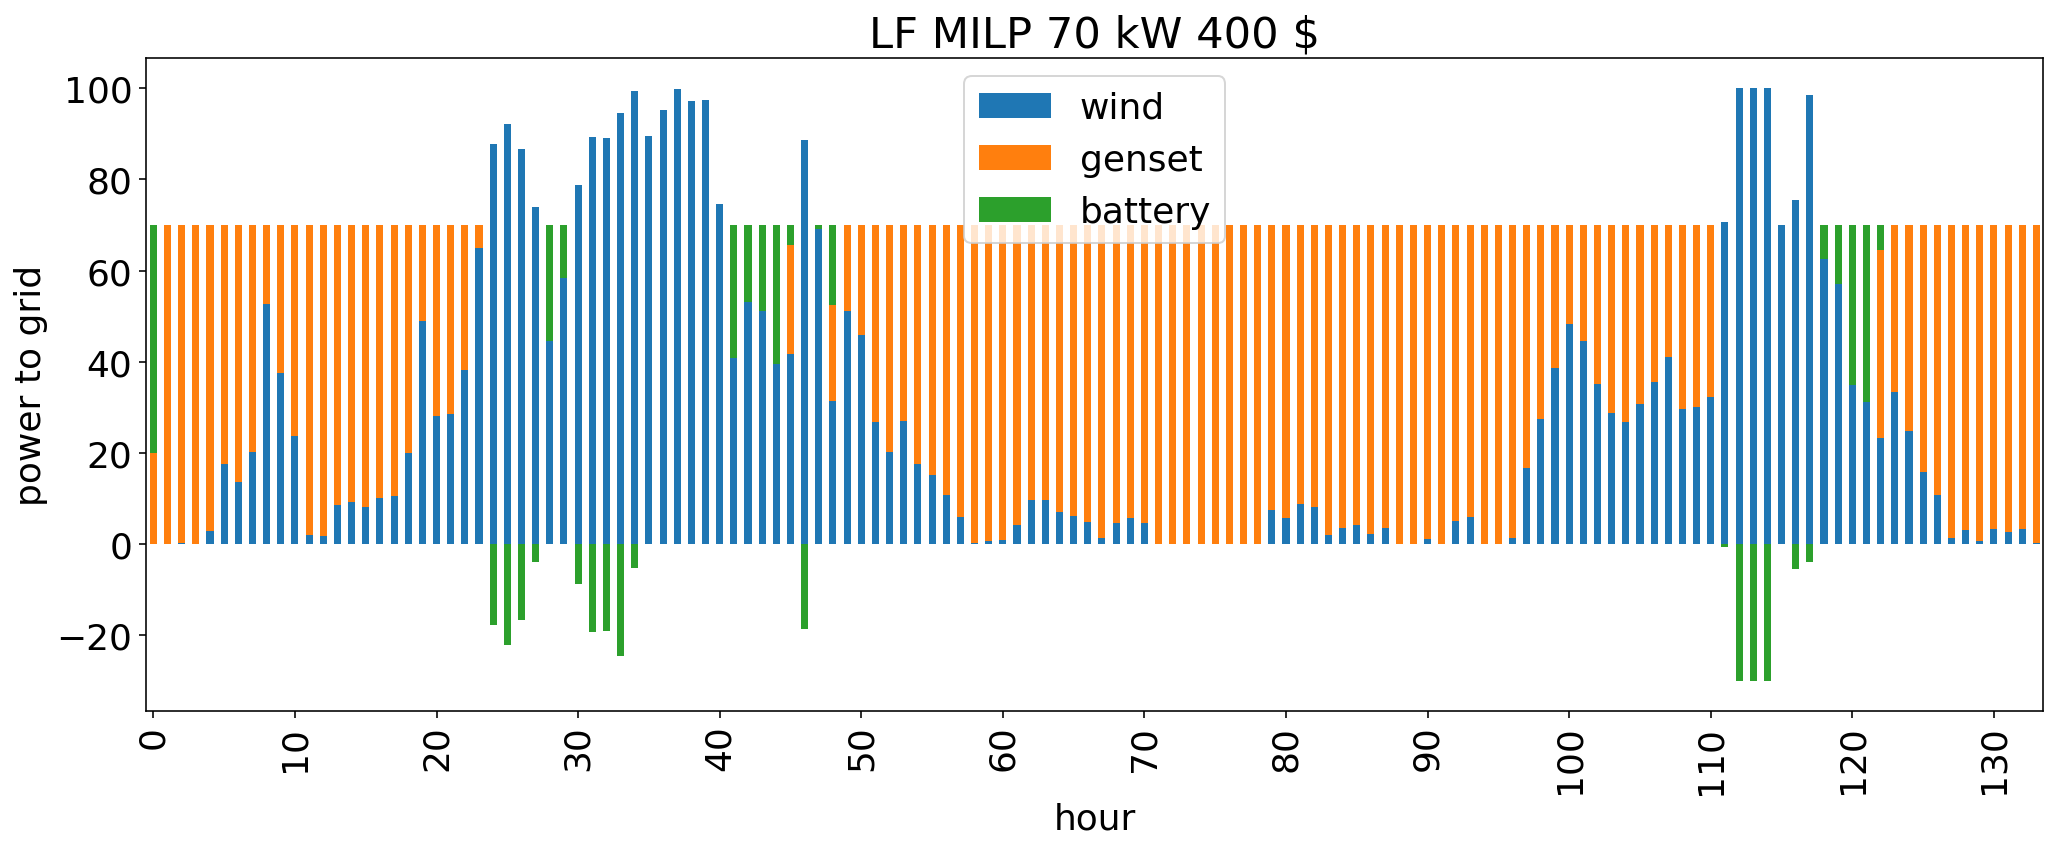

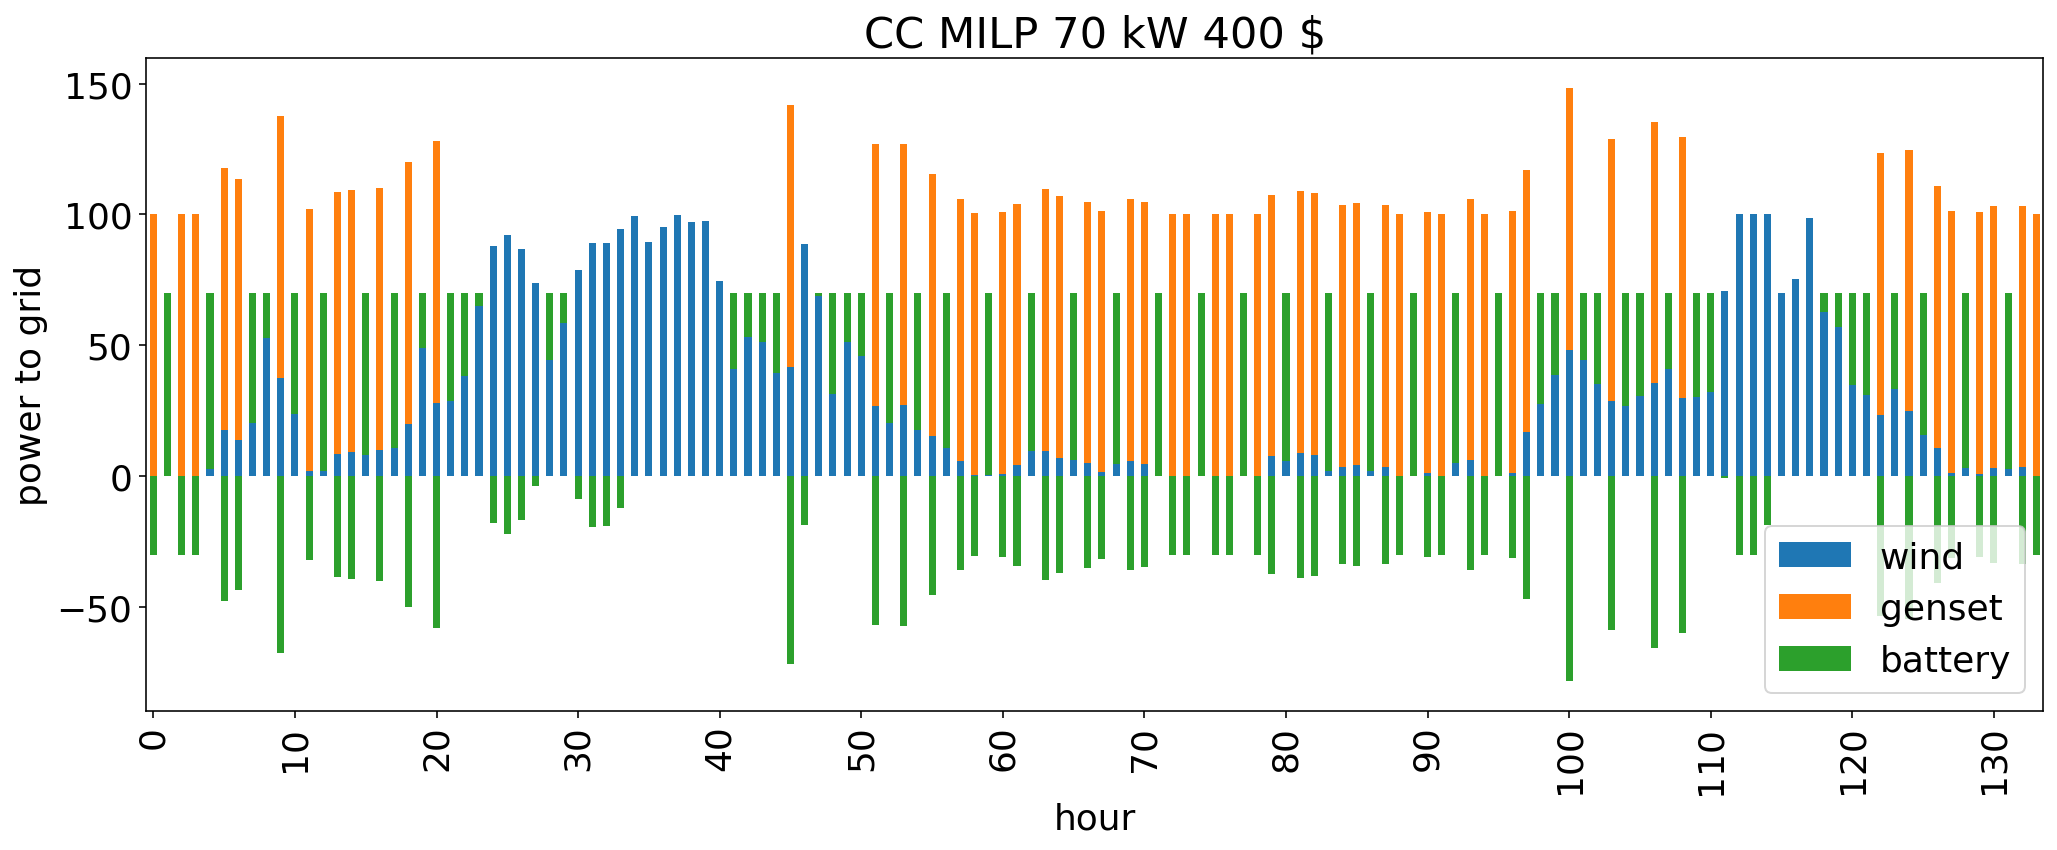

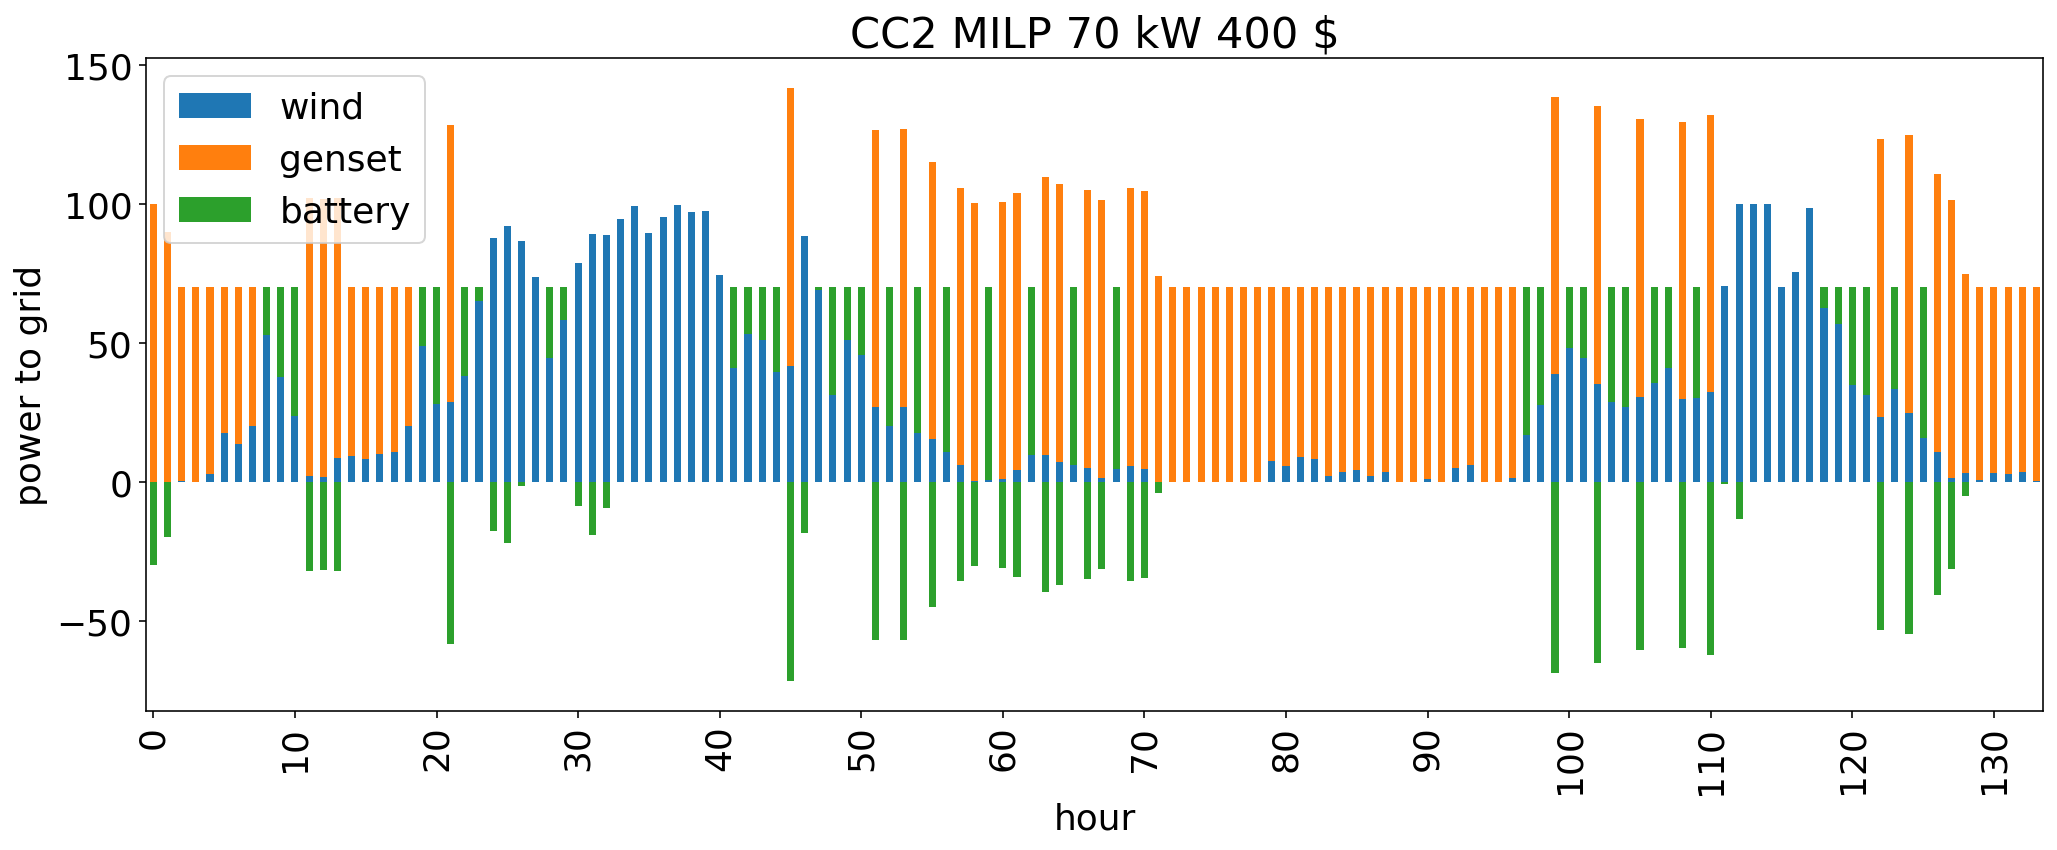

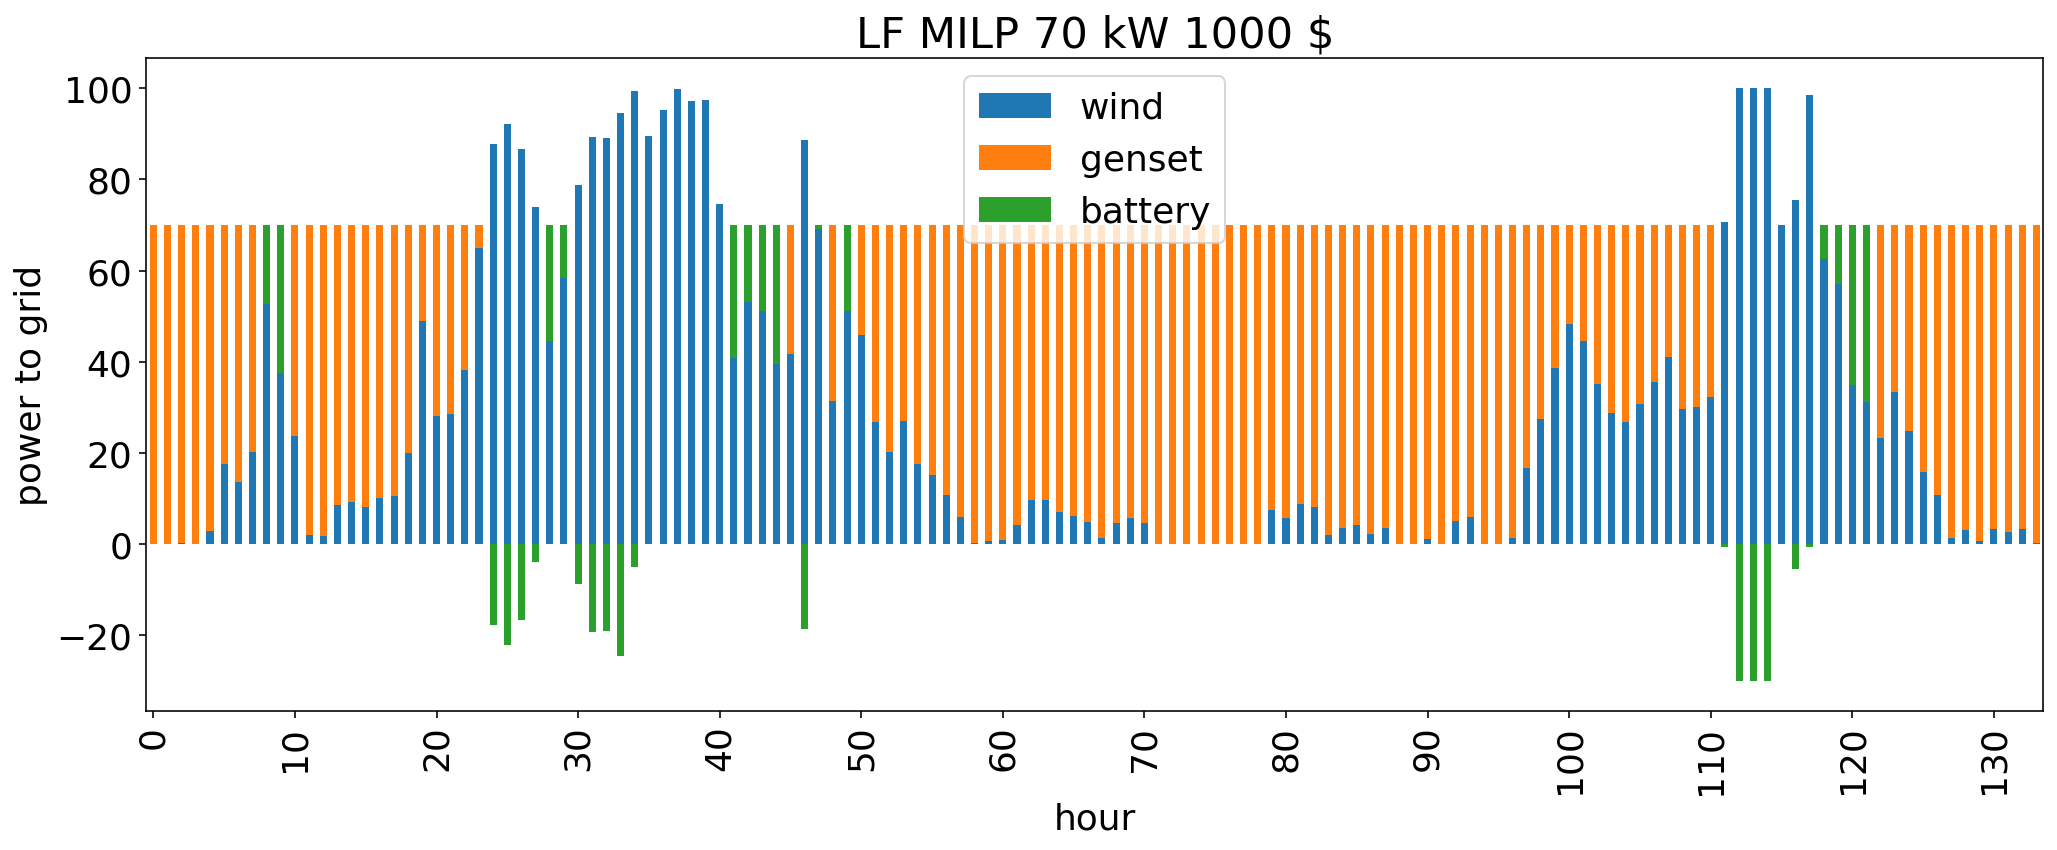

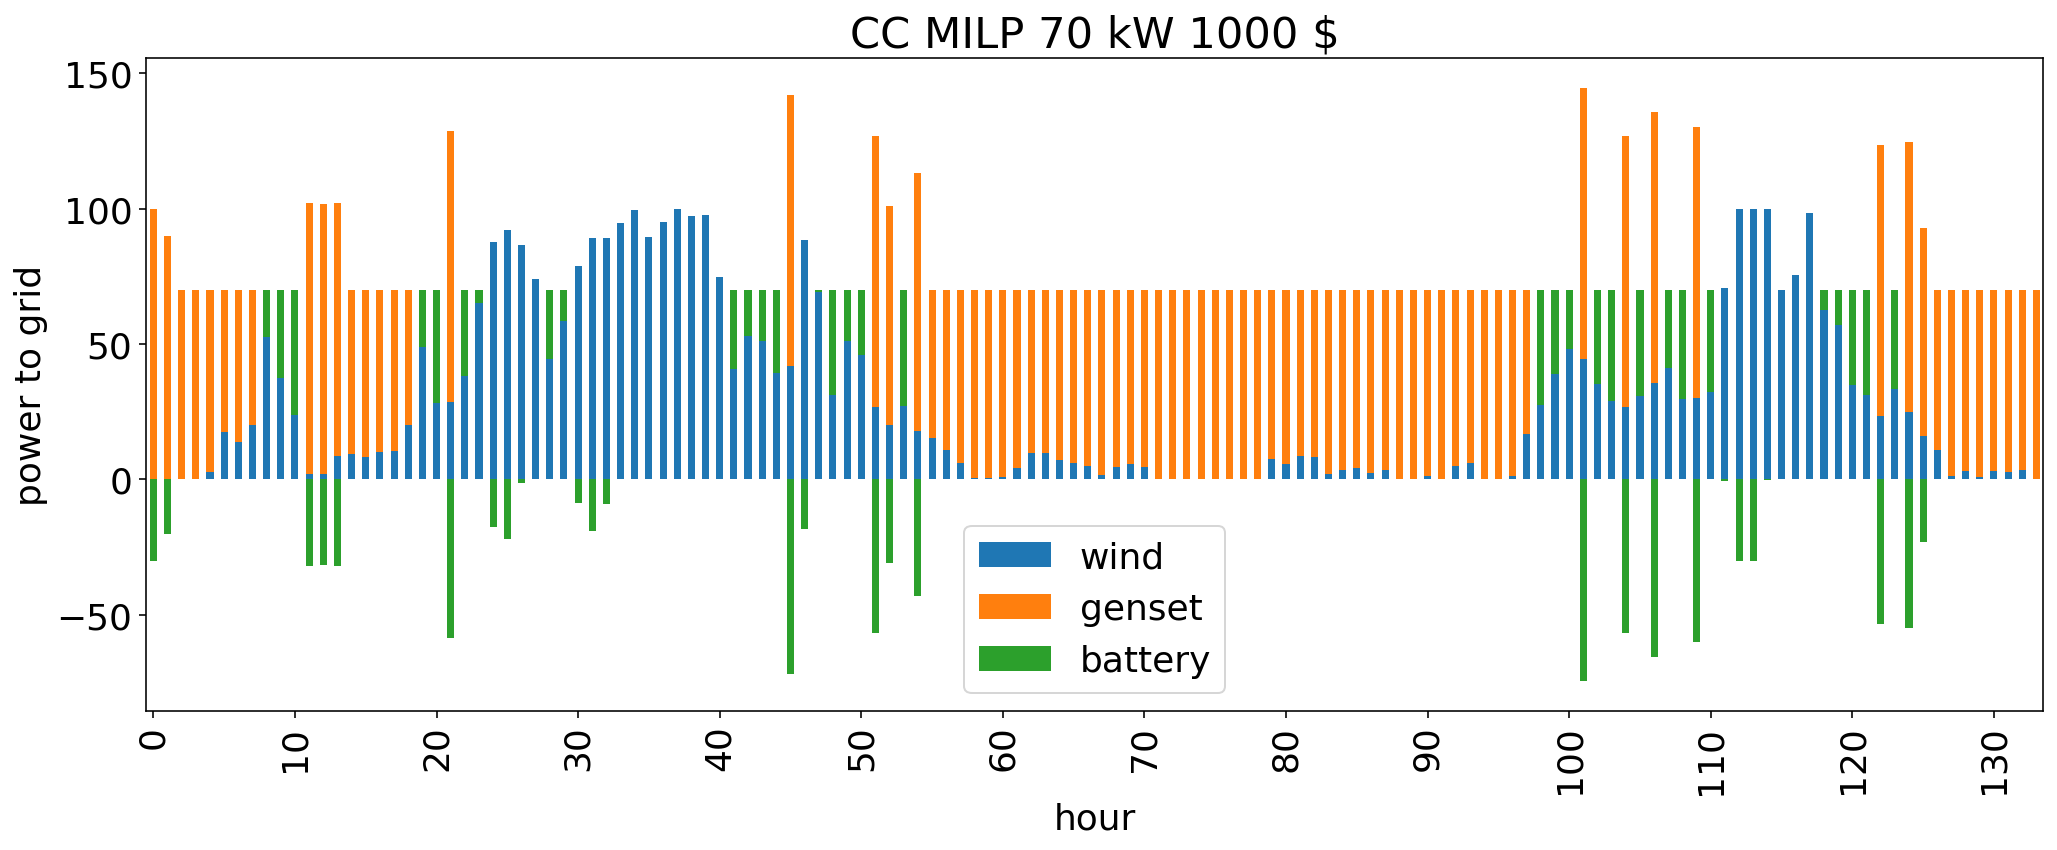

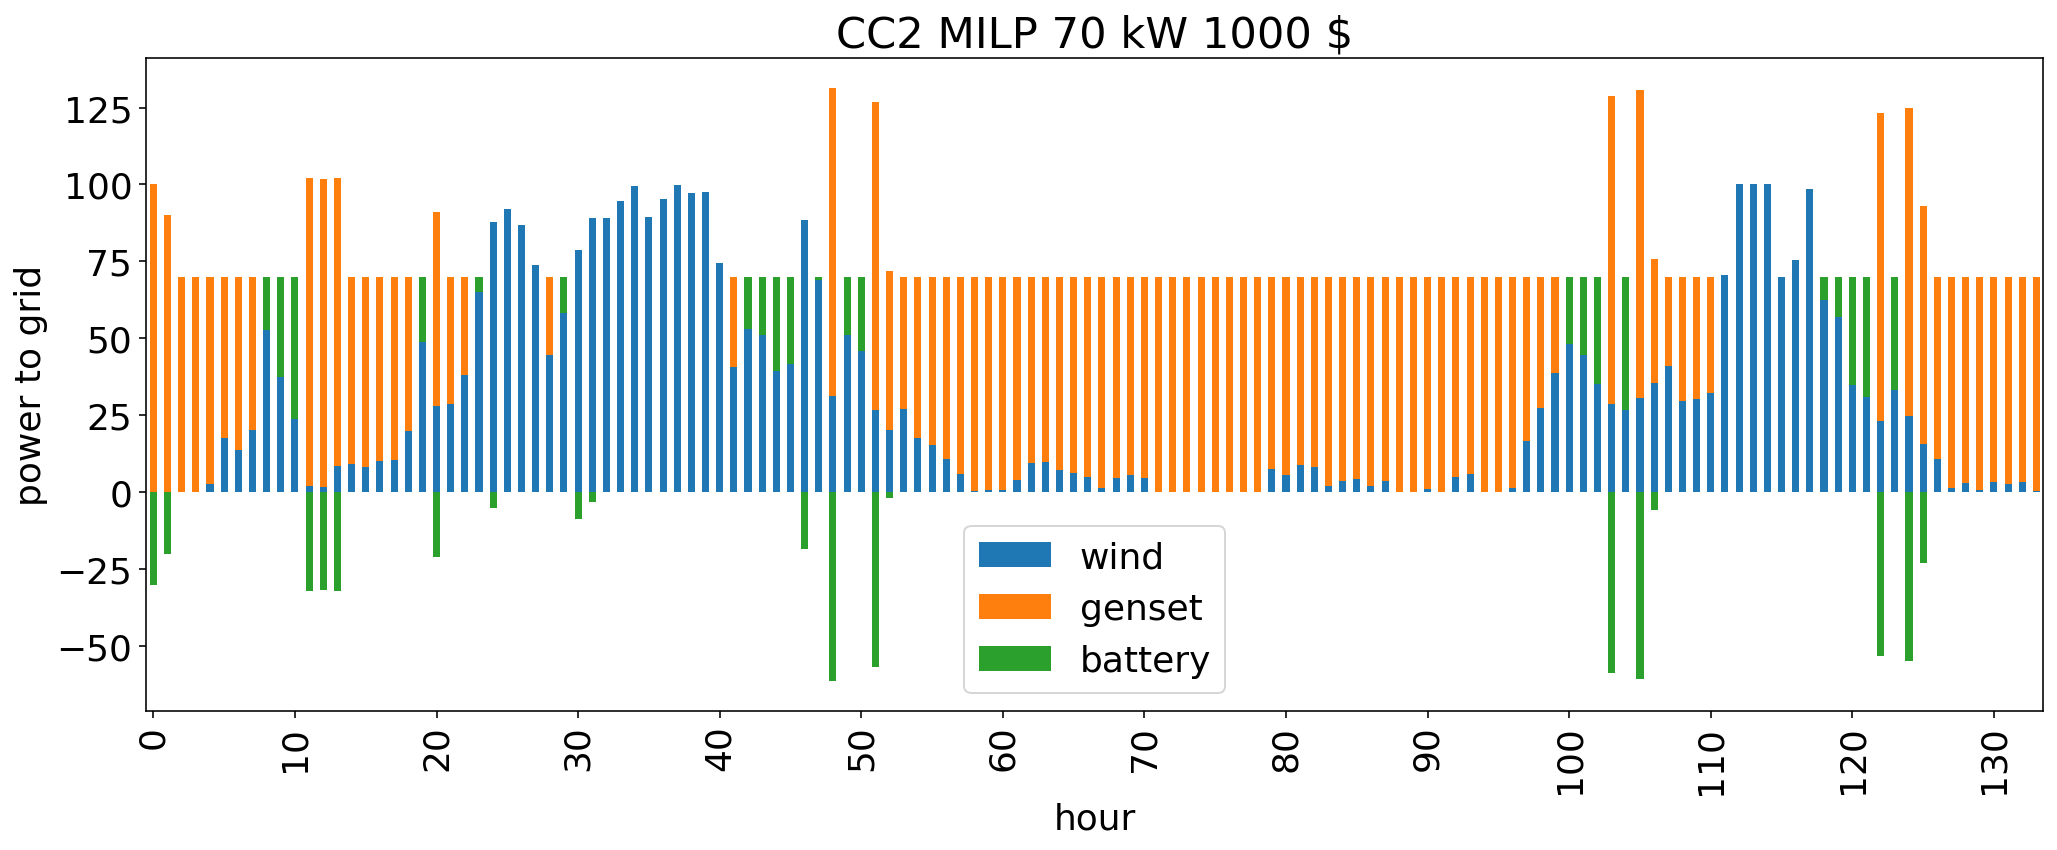

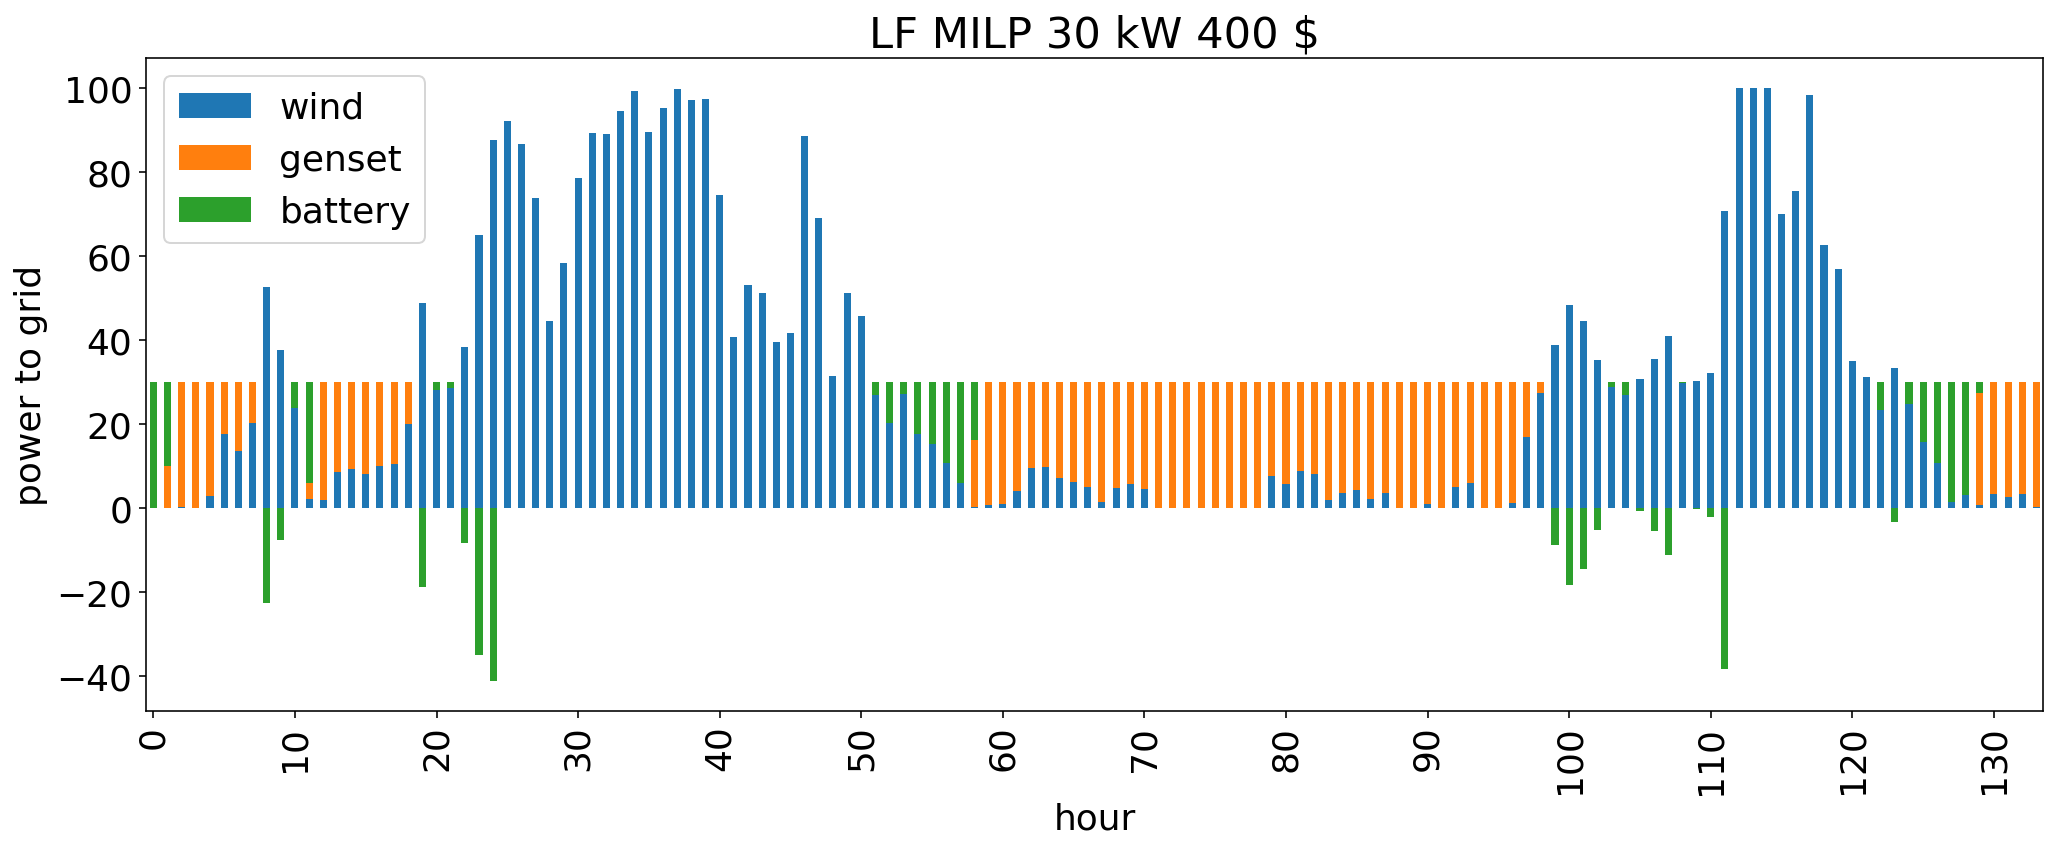

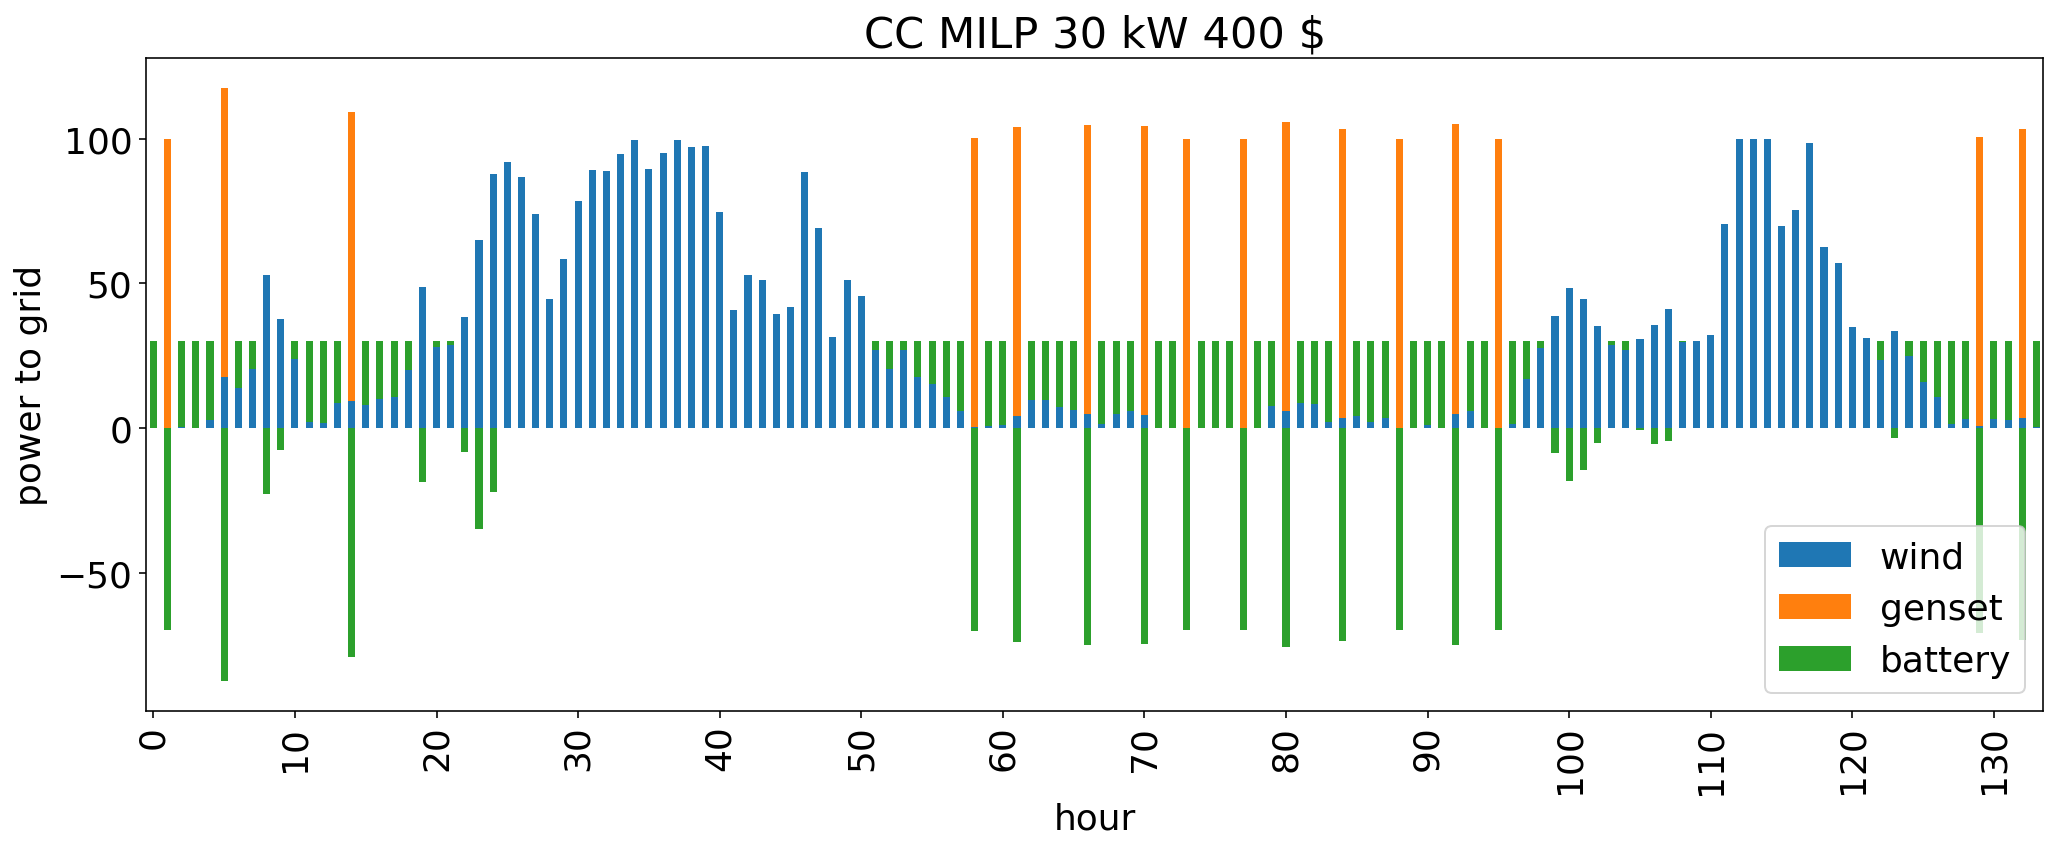

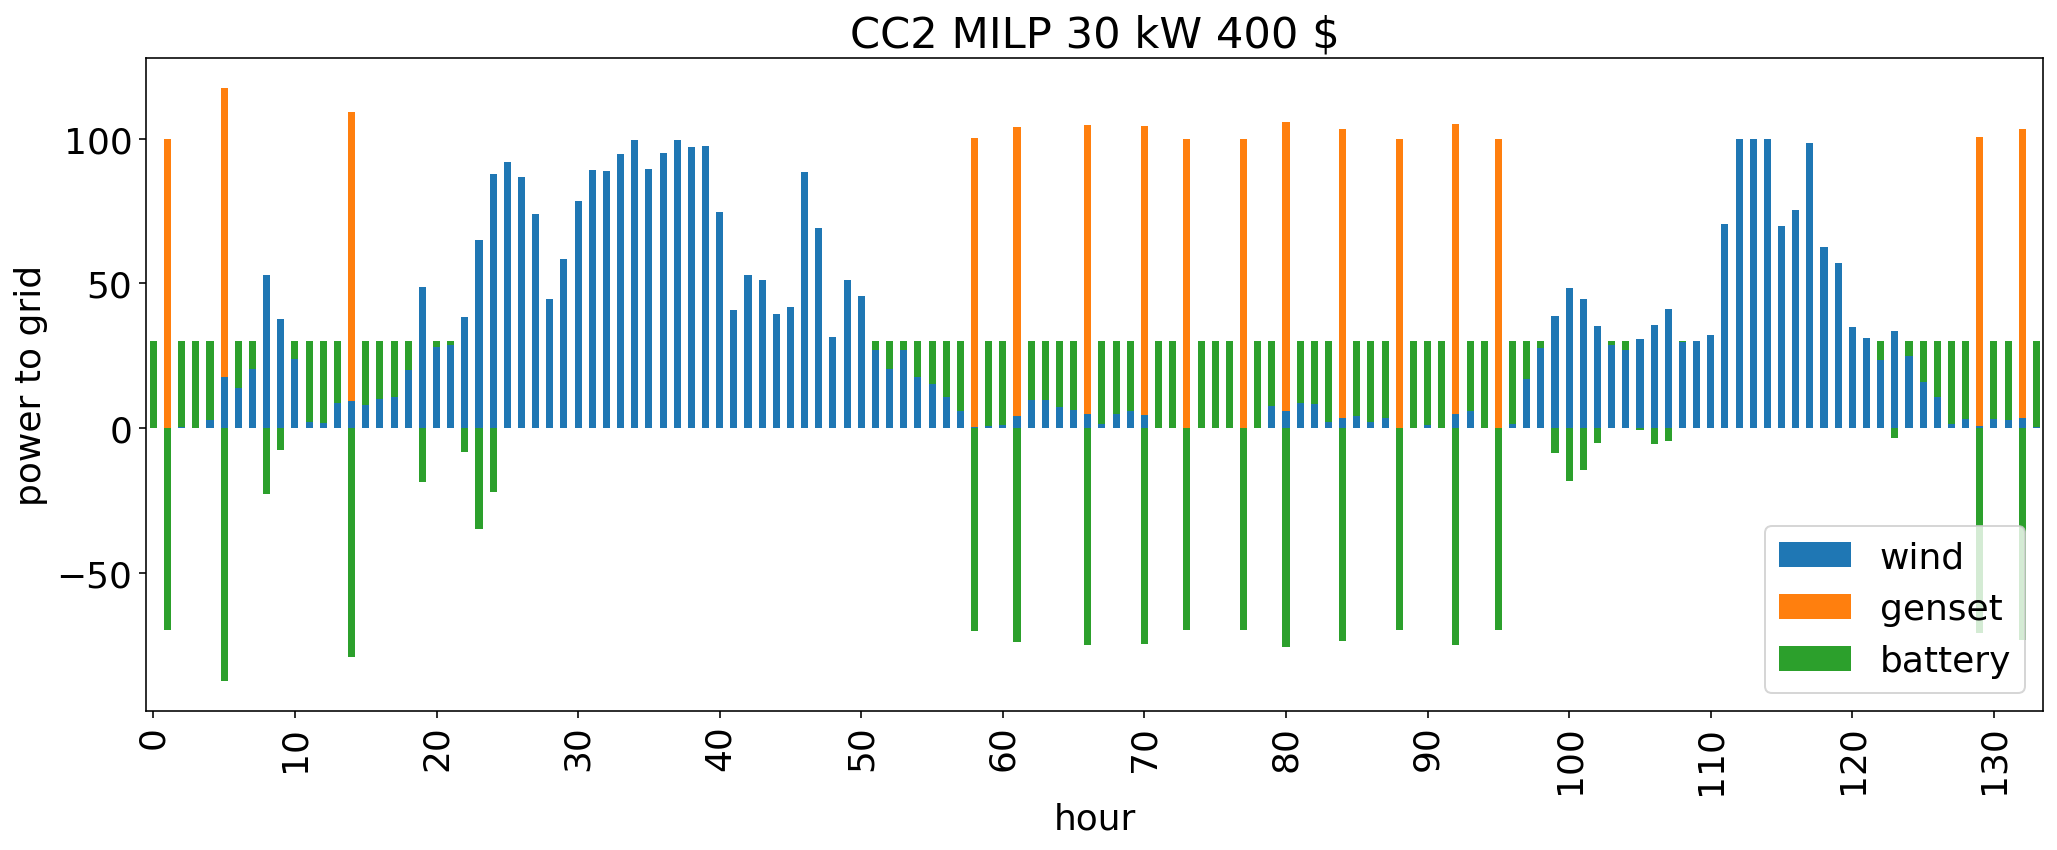

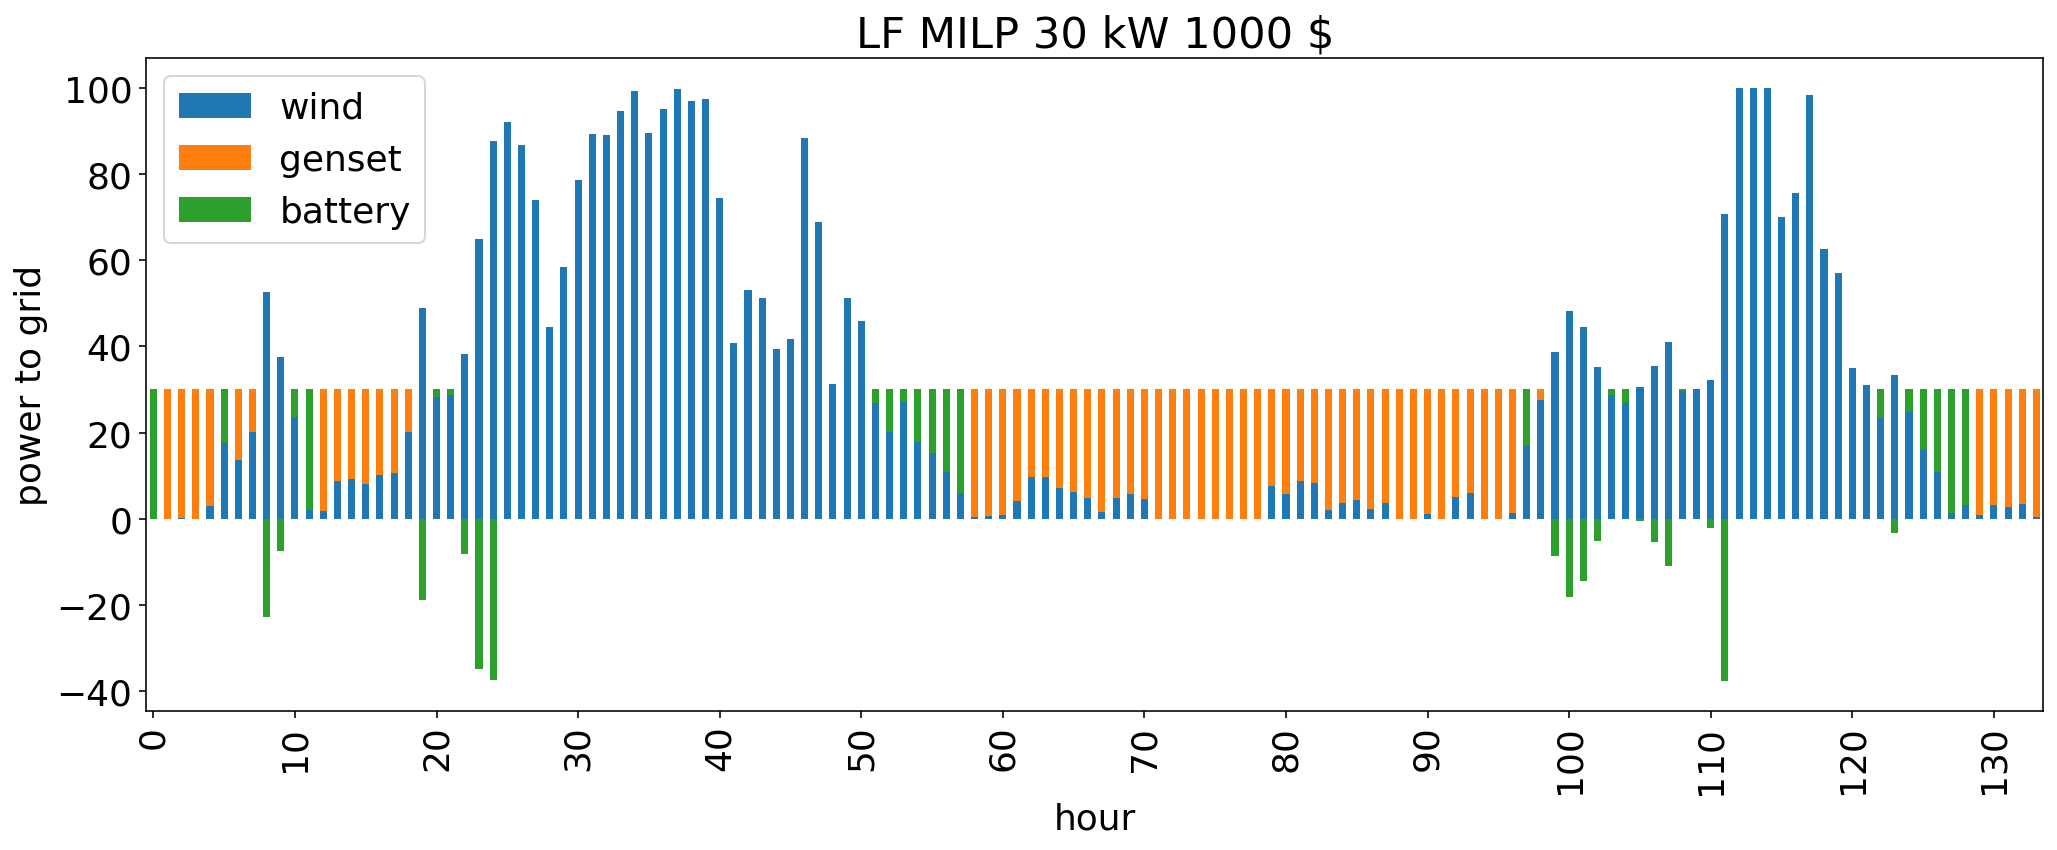

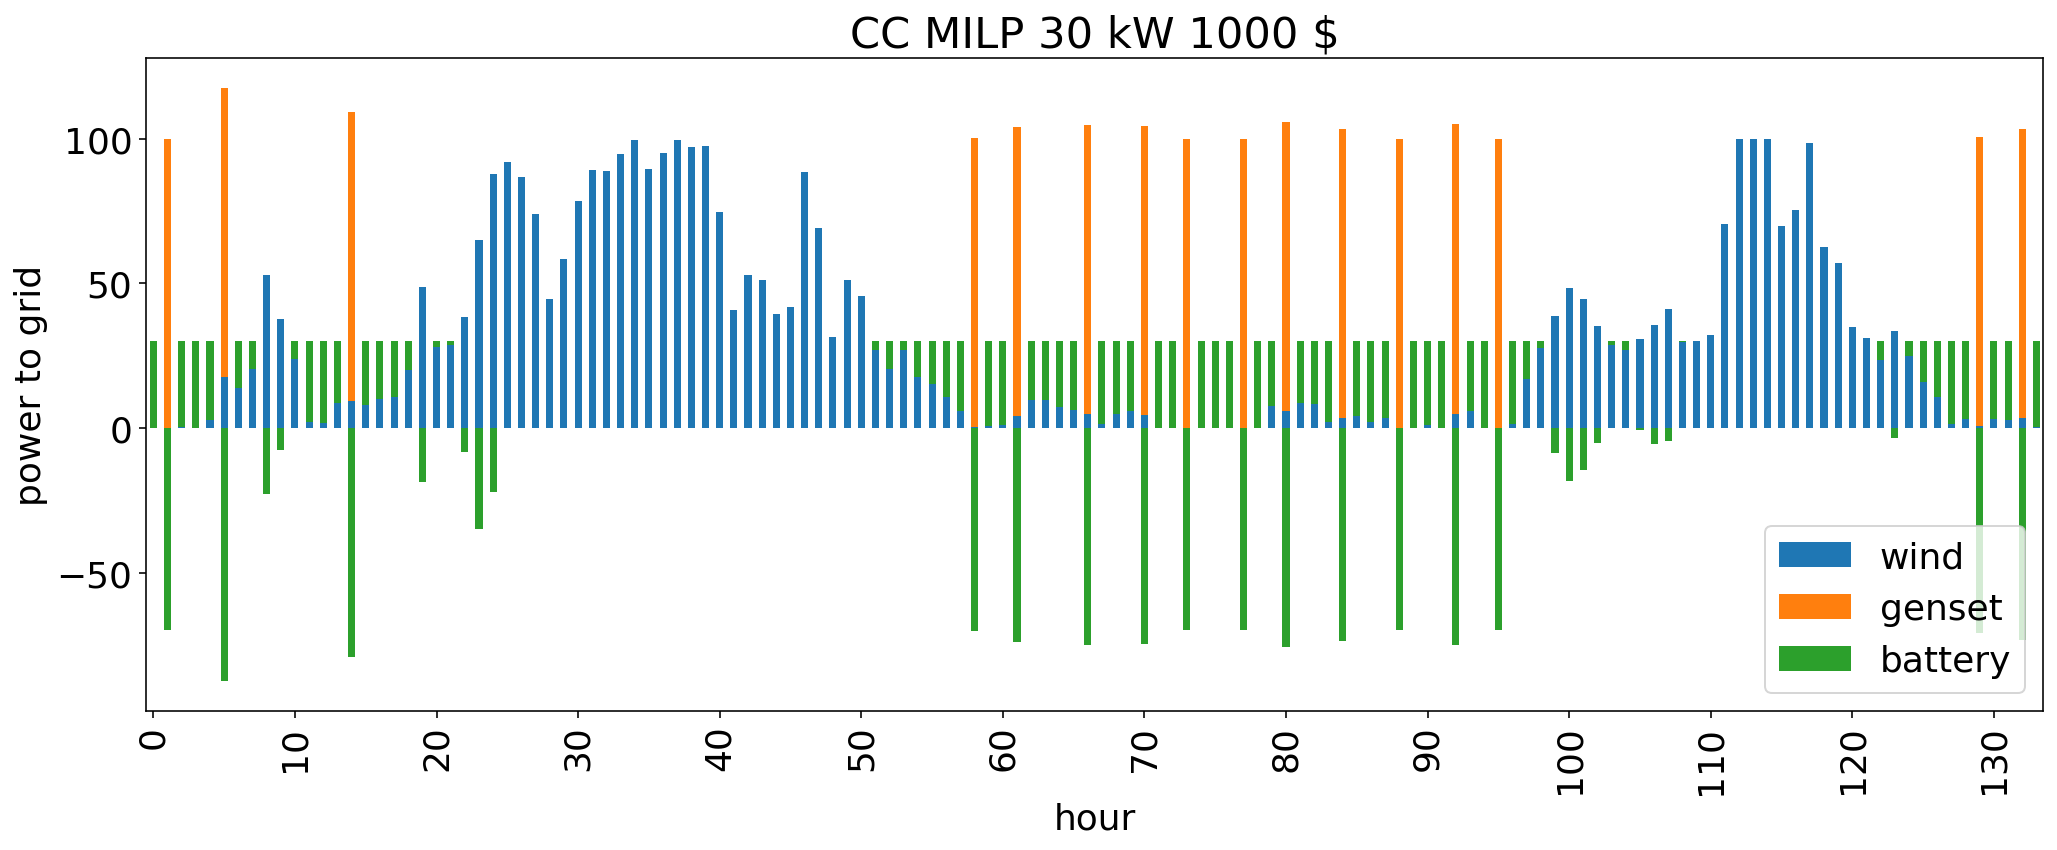

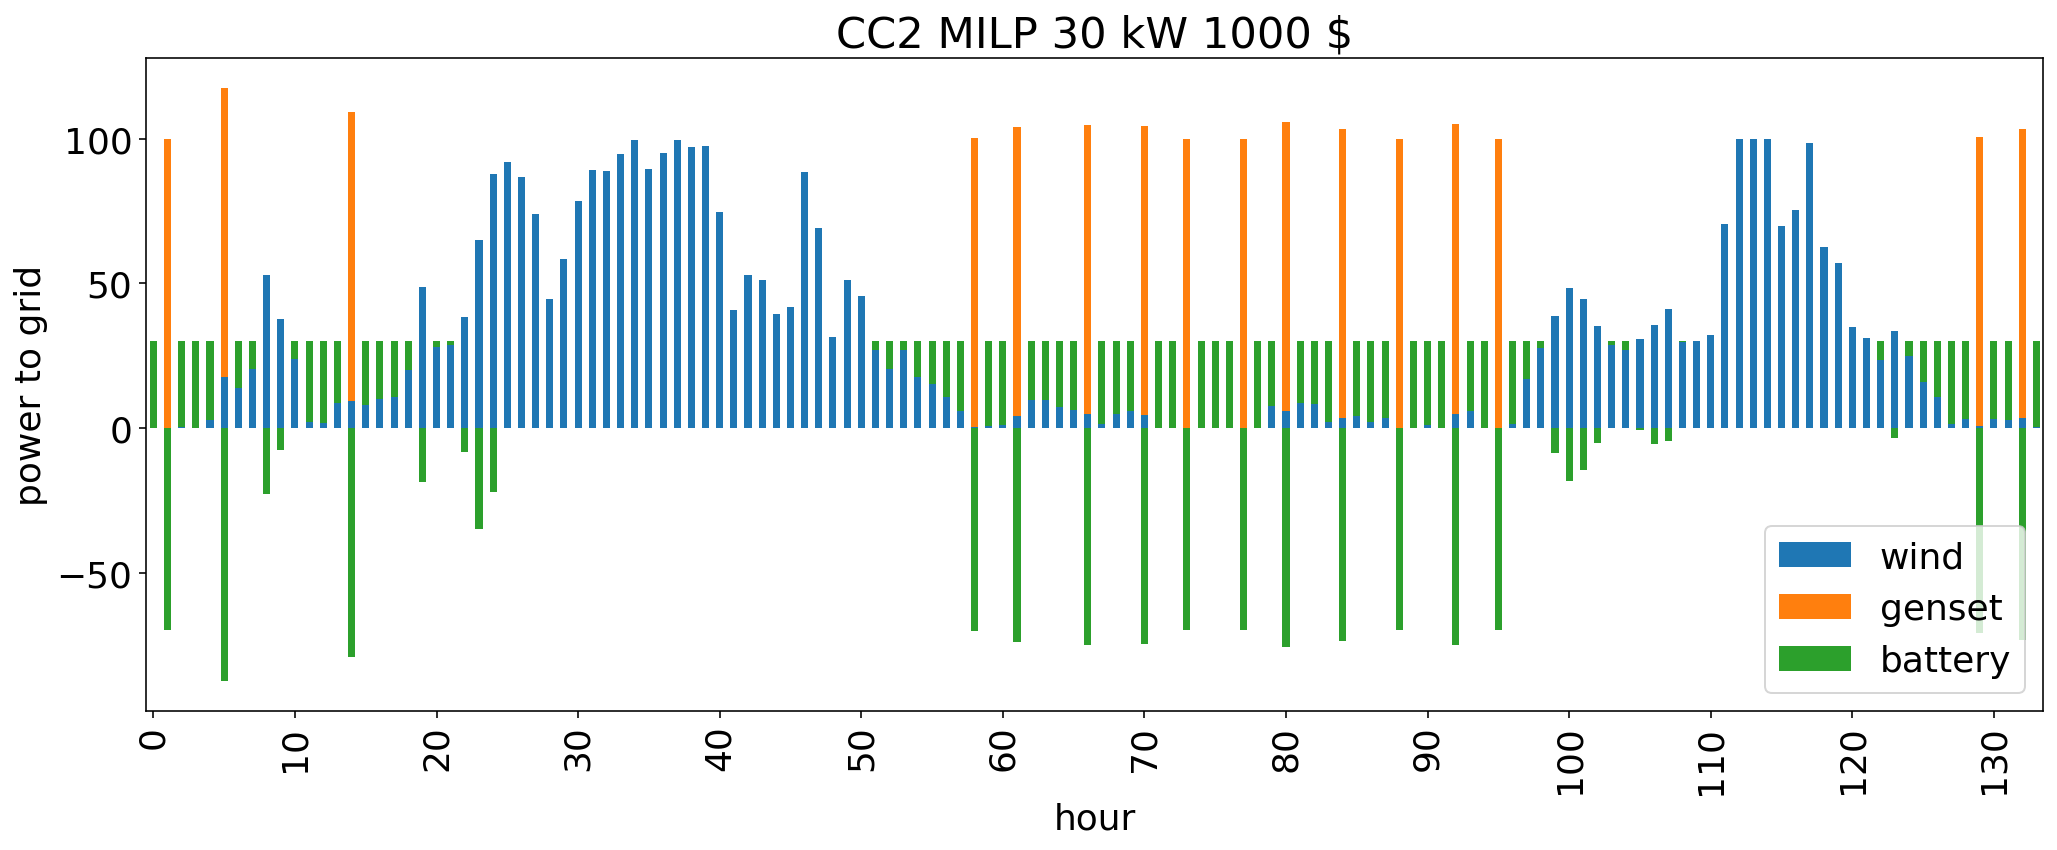

In [19]:
# 0.195*100/0.85
load = 70
capacity = 100
for load in [70, 30]:
    for battery_cost in [400, 1000]:
        for strategy in ['lf', 'cc', 'cc2']:
            battery = Battery(capacity=capacity, max_power=3*capacity, resource=3000*capacity, 
                              cost=battery_cost*capacity)
            genset = GenSet(max_power=100, consumption_intercept=3, full_load_consumption=28, cost=2.5e6/75,
                            resource=15000*100, fuel_cost=64/75, maintainance_cost=3)

            wg, gp, bp = run(load, strategy, genset, battery)
            log = pd.DataFrame()
            log['wind'], log['genset'], log['battery'] = wg, gp, -bp
            pl = log.plot(kind='bar', stacked=True, figsize=(17,6), xticks=np.arange(gp.shape[0])[::10], 
                     title= f'{strategy.upper()} MILP {load} kW {int(battery.cost/100)} $', ylabel='power to grid', xlabel='hour')
            fig = pl.get_figure()
            fig.savefig(f'pics/{strategy}_{load}_{int(battery.cost/100)}', bbox_inches='tight')
            

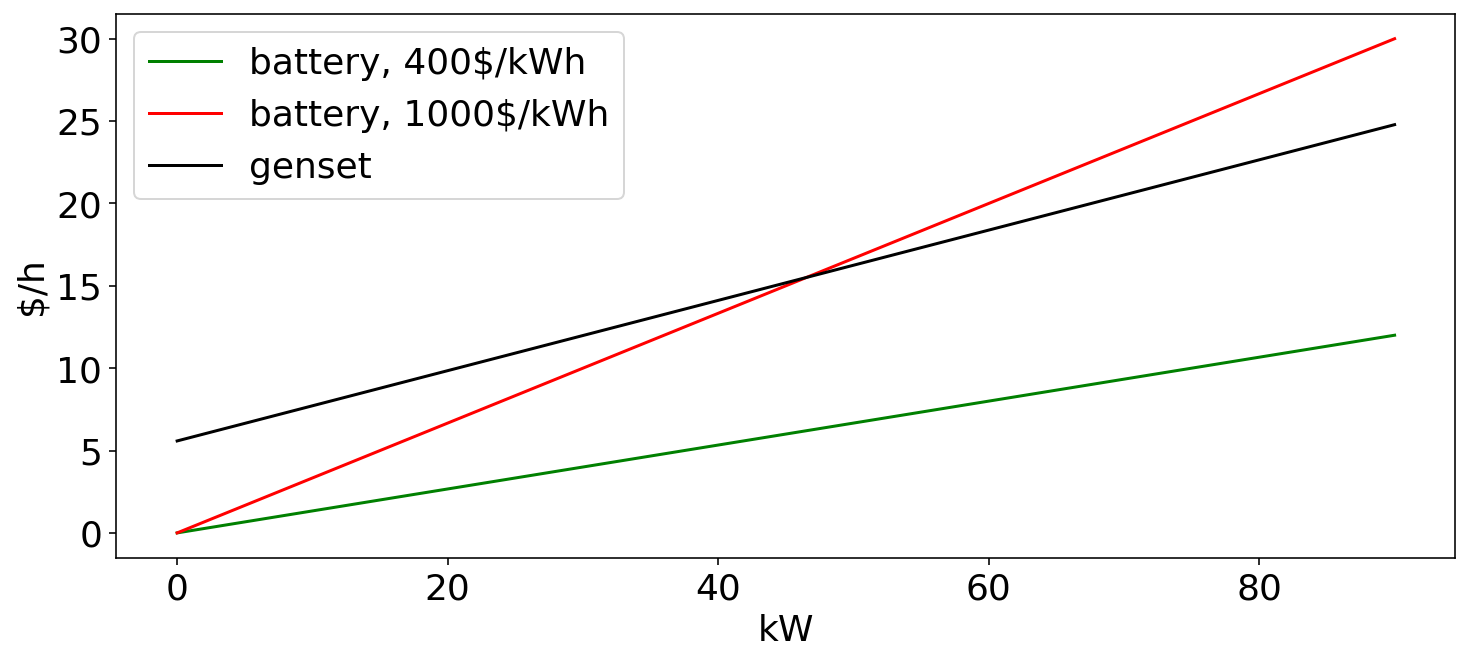

In [15]:
plt.figure(figsize=(12,5))
x = np.linspace(0, 90, 100)       
battery1 = Battery(capacity=capacity, max_power=3*capacity, resource=3000*capacity, cost=400*capacity)
battery2 = Battery(capacity=capacity, max_power=3*capacity, resource=3000*capacity, cost=1000*capacity)

b1 = battery1.cycle_cost(x)
b2 = battery2.cycle_cost(x)
g = genset.cycle_cost(x)
plt.plot(x, b1, label='battery, 400$/kWh', color='g')
plt.plot(x, b2, label='battery, 1000$/kWh', color='r')
plt.plot(x, g, label='genset', color='k')
# plt.title('Power cost')
plt.ylabel('$/h')
plt.xlabel('kW')
plt.legend()
plt.savefig('/home/demyan/Downloads/energy_cost.jpeg', format='jpeg')

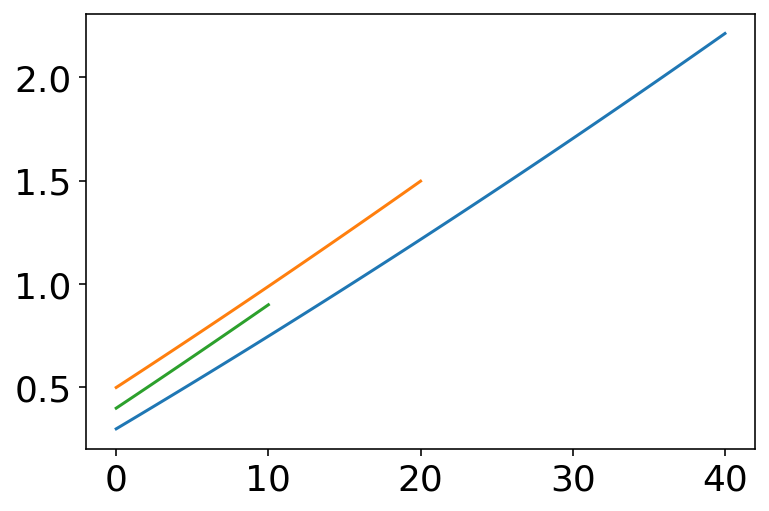

In [16]:
# from firefly arctile

p1 = 0.0001, 0.0438, 0.3, 0, 40
p2 = 0.0001, 0.0479, 0.5, 0, 20
p3 = 0.0001, 0.0490, 0.4, 0, 10

def plot_diesel_cost(p):
    x = np.linspace(p[3], p[4], 100)
    y = p[0] * x**2 + p[1] * x + p[2]
    plt.plot(x, y)
    
plot_diesel_cost(p1)
plot_diesel_cost(p2)
plot_diesel_cost(p3)